# Healthy State Reconstruction Model (GRU) - Modified

This notebook implements a GRU-based model to reconstruct/predict the healthy state of 'W' and 'X' sensor data (18 columns). 
Normalization Stats are computed purely from the Training set to strictly prevent data leakage and saved for inference.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import joblib
import random
import os
import copy
import matplotlib.pyplot as plt

## 1. Data Loading & Preprocessing (Strict No-Leakage)

- Load Parquet file
- Determine Window Indices
- **Split Train/Val by UNIT (Reserve 1 unit for Val, rest for Train)**
- **Fit Scaler ONLY on Training Units**
- Transform Data
- Create Dataset (Returns full 18-col window and 18-col target)

In [2]:
# Load Data
data_path = r'c:\Users\Bilge\OneDrive\Masaüstü\N-CMAPSS RUL\healthy state\DS02_healthyStateTrain.parquet'
df = pd.read_parquet(data_path)

# Ensure sorted by unit and cycle
df = df.sort_values(by=['unit', 'cycle']).reset_index(drop=True)

# Define columns
w_cols = ['alt', 'Mach', 'TRA', 'T2']
x_cols = [c for c in df.columns if c not in ['unit', 'cycle', 'hs'] + w_cols]
feature_cols = w_cols + x_cols

print(f"Feature columns ({len(feature_cols)}): {feature_cols}")

# Helper to find valid indices for specific units
def get_indices_for_units(data_df, selected_units, window_length=64):
    valid_indices = []
    grouped = data_df.groupby('unit')
    cumulative_len = 0
    for unit_id, group in grouped:
        group_len = len(group)
        if unit_id in selected_units:
             if group_len >= window_length:
                start_indices = np.arange(cumulative_len, cumulative_len + group_len - window_length + 1)
                valid_indices.extend(start_indices)
        cumulative_len += group_len
    return np.array(valid_indices)

# 1. Split Units into Train and Validation
units = df['unit'].unique()
val_unit = units[-1] # Reserve the last unit for validation
train_units = units[:-1]

print(f"All Units: {units}")
print(f"Train Units: {train_units}")
print(f"Validation Unit: {val_unit}")

# 2. Normalize Data (Fit ONLY on Training Units)
scaler = StandardScaler()
train_df_for_scaler = df[df['unit'].isin(train_units)]
scaler.fit(train_df_for_scaler[feature_cols])

# Save Scaler
joblib.dump(scaler, 'normalization_params.pkl')
print("Scaler saved to 'normalization_params.pkl'")

# Transform the entire dataframe (Validation data is transformed using Train stats)
df[feature_cols] = scaler.transform(df[feature_cols])
print("Normalization completed: Scaler fit on training units only.")

# 3. Get valid window start indices for Train and Val
train_indices = get_indices_for_units(df, train_units, window_length=64)
val_indices = get_indices_for_units(df, [val_unit], window_length=64)

print(f"Training windows: {len(train_indices)}")
print(f"Validation windows: {len(val_indices)}")

Feature columns (18): ['alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']
All Units: [ 2.  5. 10. 16. 18. 20.]
Train Units: [ 2.  5. 10. 16. 18.]
Validation Unit: 20.0
Scaler saved to 'normalization_params.pkl'
Normalization completed: Scaler fit on training units only.
Training windows: 953056
Validation windows: 193291


In [3]:
# 4. Create Dataset Class
class LazySlidingWindowDataset(Dataset):
    def __init__(self, data_df, valid_indices_subset, feature_columns=None, window_length=64, mode='train'):
        self.window_length = window_length
        self.mode = mode
        self.feature_columns = feature_columns
        
        # Validate feature_columns
        if feature_columns is None:
            # Fallback to global if not passed (not recommended but for backward compat)
            # But better to raise error or warn. Here we assume caller passes it.
            raise ValueError("feature_columns must be provided")
            
        # Store data as a single numpy array to save memory
        self.data = data_df[feature_columns].values.astype(np.float32)
        # self.targets removed to save memory
        
        # Use the specific subset of indices (Train or Val) provided
        self.valid_indices = valid_indices_subset
        
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        start_idx = self.valid_indices[idx]
        end_idx = start_idx + self.window_length
        
        # Input: (64, 18)
        window = self.data[start_idx:end_idx].copy()
        
        # Target: (14,) - the last time step of the window, excluding W (first 4 columns)
        # The model is trained to reconstruct the last step of X given the sequence of W+X
        target = window[-1, 4:].copy() # Exclude W (alt, Mach, TRA, T2)
        
        return torch.from_numpy(window), torch.from_numpy(target)

# 5. Instantiate Datasets with the unit-based split indices
print("Instantiating Datasets...")
train_dataset = LazySlidingWindowDataset(
    df, 
    valid_indices_subset=train_indices, 
    feature_columns=feature_cols,
    window_length=64, 
    mode='train'
)

val_dataset = LazySlidingWindowDataset(
    df, 
    valid_indices_subset=val_indices, 
    feature_columns=feature_cols,
    window_length=64, 
    mode='val'
)

print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Val Dataset Length: {len(val_dataset)}")

# DataLoaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
print("DataLoaders created.")

Instantiating Datasets...
Train Dataset Length: 953056
Val Dataset Length: 193291
DataLoaders created.


## 3. Model Architecture

- Input: (64, 18)
- GRU 1: 48 units (return_sequences=True)
- GRU 2: 16 units (return_sequences=True)
- GRU 3: 6 units (return_sequences=False)
- Dense 1: 16 units
- Dense 2: 24 units
- Output: 14 units (Fully Connected - X only)

In [4]:
class GRUReconstructor(nn.Module):
    def __init__(self, input_dim=18, output_dim=14, dropout=0.2):
        super(GRUReconstructor, self).__init__()
        
        self.gru1 = nn.GRU(input_dim, 48, batch_first=True)
        self.gru2 = nn.GRU(48, 16, batch_first=True)
        self.gru3 = nn.GRU(16, 6, batch_first=True)
        
        self.fc1 = nn.Linear(6, 16)
        self.fc2 = nn.Linear(16, 24)
        self.fc3 = nn.Linear(24, output_dim)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x: (batch, 64, 18)
        
        # GRU Layers
        out, _ = self.gru1(x) # (batch, 64, 48)
        out, _ = self.gru2(out) # (batch, 64, 16)
        out, _ = self.gru3(out) # (batch, 64, 6)
        
        # Take only the last time step
        last_step = out[:, -1, :] # (batch, 6)
        
        # Dense Layers
        out = self.relu(self.fc1(last_step))
        out = self.relu(self.fc2(out))
        output = self.fc3(out) # Linear activation for output
        
        return output

## 4. Training Loop

- Optimizer: AdamW(weight_decay=0.1)
- Loss: MSELoss
- Custom Scheduler: Patience=4, reduce LR, load best model. Stop at 3rd trigger.
- Early Stopping: Save best model.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GRUReconstructor(input_dim=18, output_dim=14).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.MSELoss()

Using device: cuda


In [6]:
epochs = 50
patience = 4
trigger_count = 0
max_triggers = 3
best_val_loss = float('inf')
best_model_path = 'best_model.pth'
epochs_no_improve = 0

train_losses = []
val_losses = []

print("Starting training loop...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
            
    epoch_val_loss = val_running_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.6f} - Val Loss: {epoch_val_loss:.6f}")
    
    # Scheduler & Early Stopping Logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        # print("Saved best model.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= patience:
            trigger_count += 1
            print(f"Trigger {trigger_count}/{max_triggers}: Reducing LR and reloading best model.")
            
            if trigger_count >= max_triggers:
                print("Max triggers reached. Stopping training.")
                break
            
            # Load best model
            model.load_state_dict(torch.load(best_model_path))
            
            # Reduce LR
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.5 # Reduce by factor of 0.5 (or 0.1)
                print(f"New Learning Rate: {param_group['lr']}")
            
            # Reset counter
            epochs_no_improve = 0

Starting training loop...
Epoch 1/50 - Train Loss: 0.042834 - Val Loss: 0.000488
Epoch 2/50 - Train Loss: 0.000243 - Val Loss: 0.000196
Epoch 3/50 - Train Loss: 0.000155 - Val Loss: 0.000153
Epoch 4/50 - Train Loss: 0.000127 - Val Loss: 0.000116
Epoch 5/50 - Train Loss: 0.000107 - Val Loss: 0.000100
Epoch 6/50 - Train Loss: 0.000095 - Val Loss: 0.000151
No improvement for 1 epochs.
Epoch 7/50 - Train Loss: 0.000086 - Val Loss: 0.000090
Epoch 8/50 - Train Loss: 0.000078 - Val Loss: 0.000101
No improvement for 1 epochs.
Epoch 9/50 - Train Loss: 0.000073 - Val Loss: 0.000084
Epoch 10/50 - Train Loss: 0.000069 - Val Loss: 0.000084
No improvement for 1 epochs.
Epoch 11/50 - Train Loss: 0.000067 - Val Loss: 0.000089
No improvement for 2 epochs.
Epoch 12/50 - Train Loss: 0.000065 - Val Loss: 0.000162
No improvement for 3 epochs.
Epoch 13/50 - Train Loss: 0.000063 - Val Loss: 0.000073
Epoch 14/50 - Train Loss: 0.000060 - Val Loss: 0.000104
No improvement for 1 epochs.
Epoch 15/50 - Train Loss:

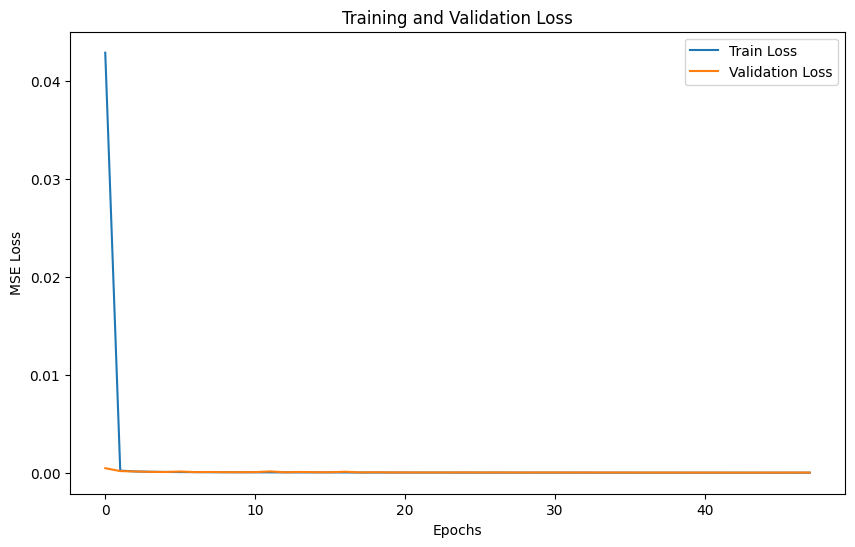

In [7]:
# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()